In [1]:
# %pip install tf_keras_vis tflite-support-nightly

# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [2]:
# import os
# from bing_image_downloader import downloader
# QUERIES = QUERIES = ["Slice Apple pie",
#                      "Slice Strawberry Pie",
#                      "Slice Apricots Pie",
#                      "Slice Pumpkin Pie",
#                      "Slice Pineapple Pie",
#                      "Slice Cherry Pie",
#                      "Slice Carrot Pie",
#                      "Slice Banana Pie",
#                      "Slice Chocolate Pie"
#                      ]
# OUTPUT_DIR = 'dataset_train'
# NB_IMAGES = 100
# 
# for query in QUERIES:
#     if not os.path.exists(os.path.join(OUTPUT_DIR, query)):
#         os.makedirs(os.path.join(OUTPUT_DIR, query))
#     downloader.download(
#         query, NB_IMAGES, OUTPUT_DIR,
#         adult_filter_off=False, force_replace=True, timeout=5, 
#     )

In [3]:
# import os
# import random
# import shutil
# 
# # Define directories
# train_dir = 'dataset_train'
# test_dir = 'dataset_test'
# 
# # Ensure the test directory exists
# os.makedirs(test_dir, exist_ok=True)
# 
# # Iterate over each query folder
# for query in os.listdir(train_dir):
#     query_train_dir = os.path.join(train_dir, query)
#     query_test_dir = os.path.join(test_dir, query)
# 
#     if not os.path.isdir(query_train_dir):
#         continue  # Skip if not a directory
# 
#     # Ensure the test directory for the query exists
#     os.makedirs(query_test_dir, exist_ok=True)
# 
#     # Get all images in the query's train directory
#     all_images = [f for f in os.listdir(query_train_dir) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
# 
#     # Calculate 20% of the images
#     num_images_to_move = int(0.2 * len(all_images))
# 
#     # Randomly select images to move
#     images_to_move = random.sample(all_images, num_images_to_move)
# 
#     # Move the images
#     for image in images_to_move:
#         src_path = os.path.join(query_train_dir, image)
#         dst_path = os.path.join(query_test_dir, image)
#         shutil.move(src_path, dst_path)
# 
#     print(f"Moved {num_images_to_move} images from {query_train_dir} to {query_test_dir}")
# 
# print("Finished moving images.")


In [4]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [5]:
train_df = create_dataframe_from_directories("dataset_train")
test_df = create_dataframe_from_directories("dataset_test")

In [6]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['Slice Apple pie', 'Slice Apricots Pie', 'Slice Banana Pie',
       'Slice Carrot Pie', 'Slice Cherry Pie', 'Slice Chocolate Pie',
       'Slice Pineapple Pie', 'Slice Pumpkin Pie', 'Slice Strawberry Pie'],
      dtype=object)

**TODO**: Display some images of your dataset

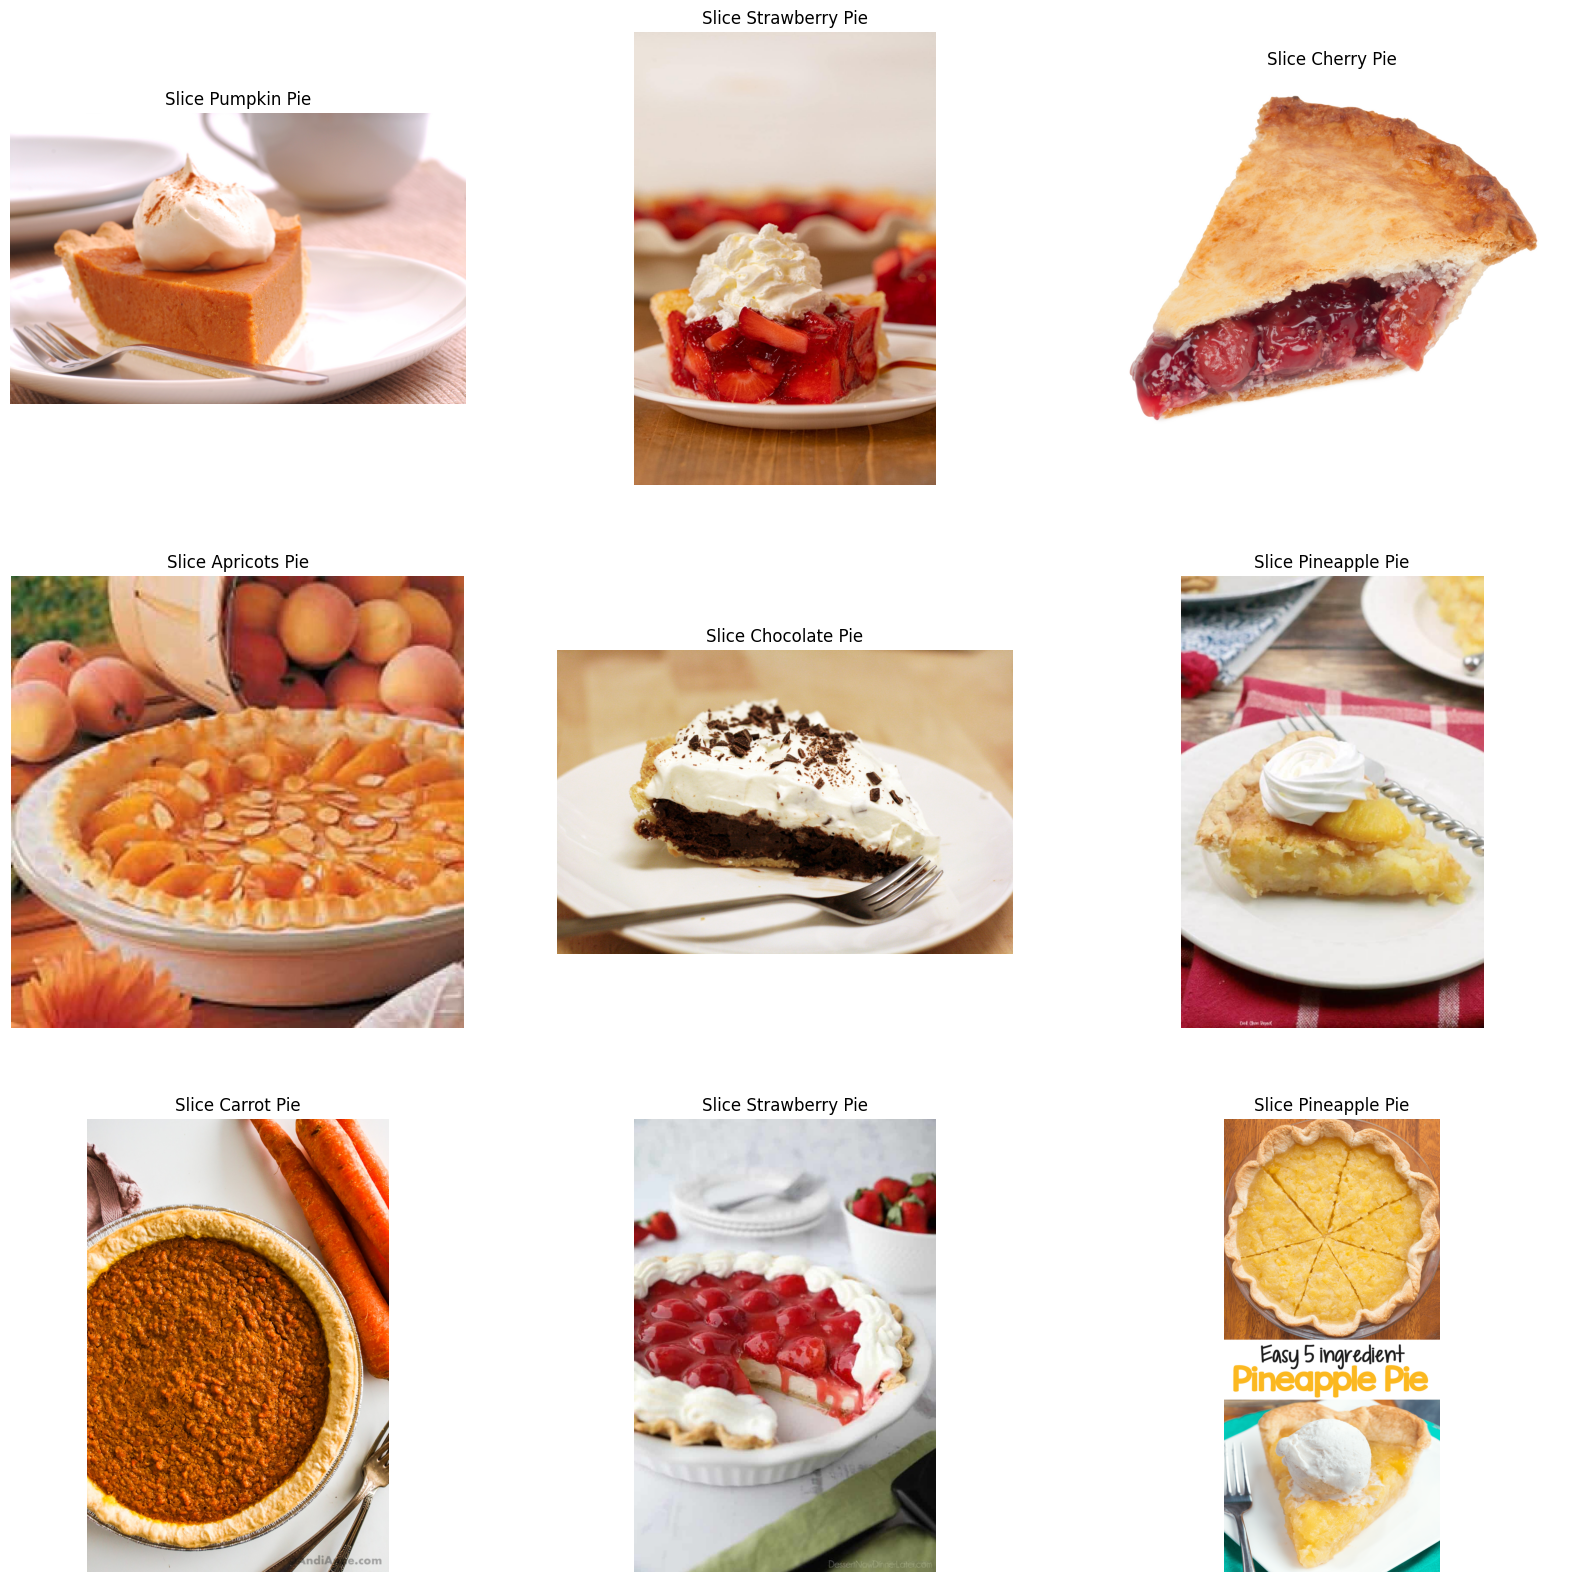

In [7]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image

plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

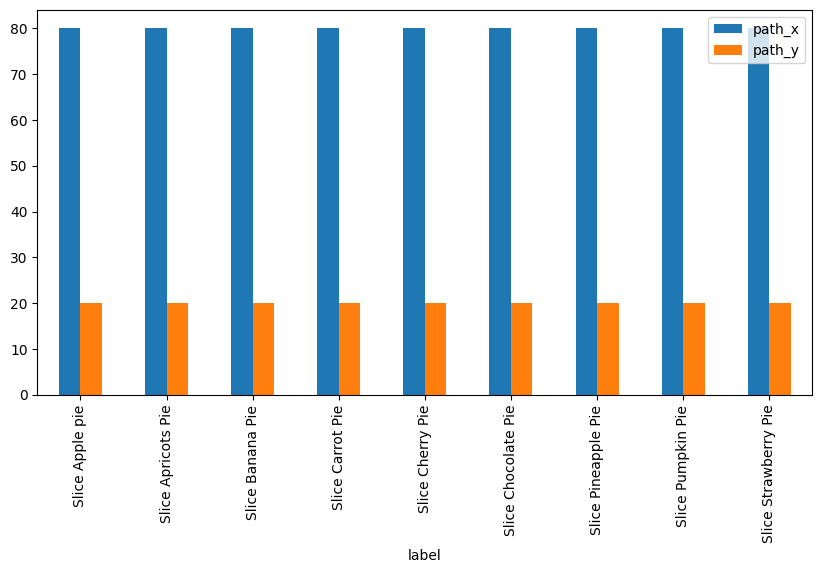

In [8]:
import matplotlib.pyplot as plt

train = train_df.groupby('label').count()
test = test_df.groupby('label').count()
merged_df = pd.merge(train, test, on=['label'])

fig, ax = plt.subplots(figsize=(10, 5))
merged_df.plot(kind='bar', ax=ax, label=['train', 'test'])
plt.show()



# Preprocessing steps

In [9]:
import PIL
import numpy as np
from keras.src.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import (
    Resizing, Rescaling,
)

from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation

    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path).convert('RGB') as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

**TODO**: plot examples of preprocessed and augmented images

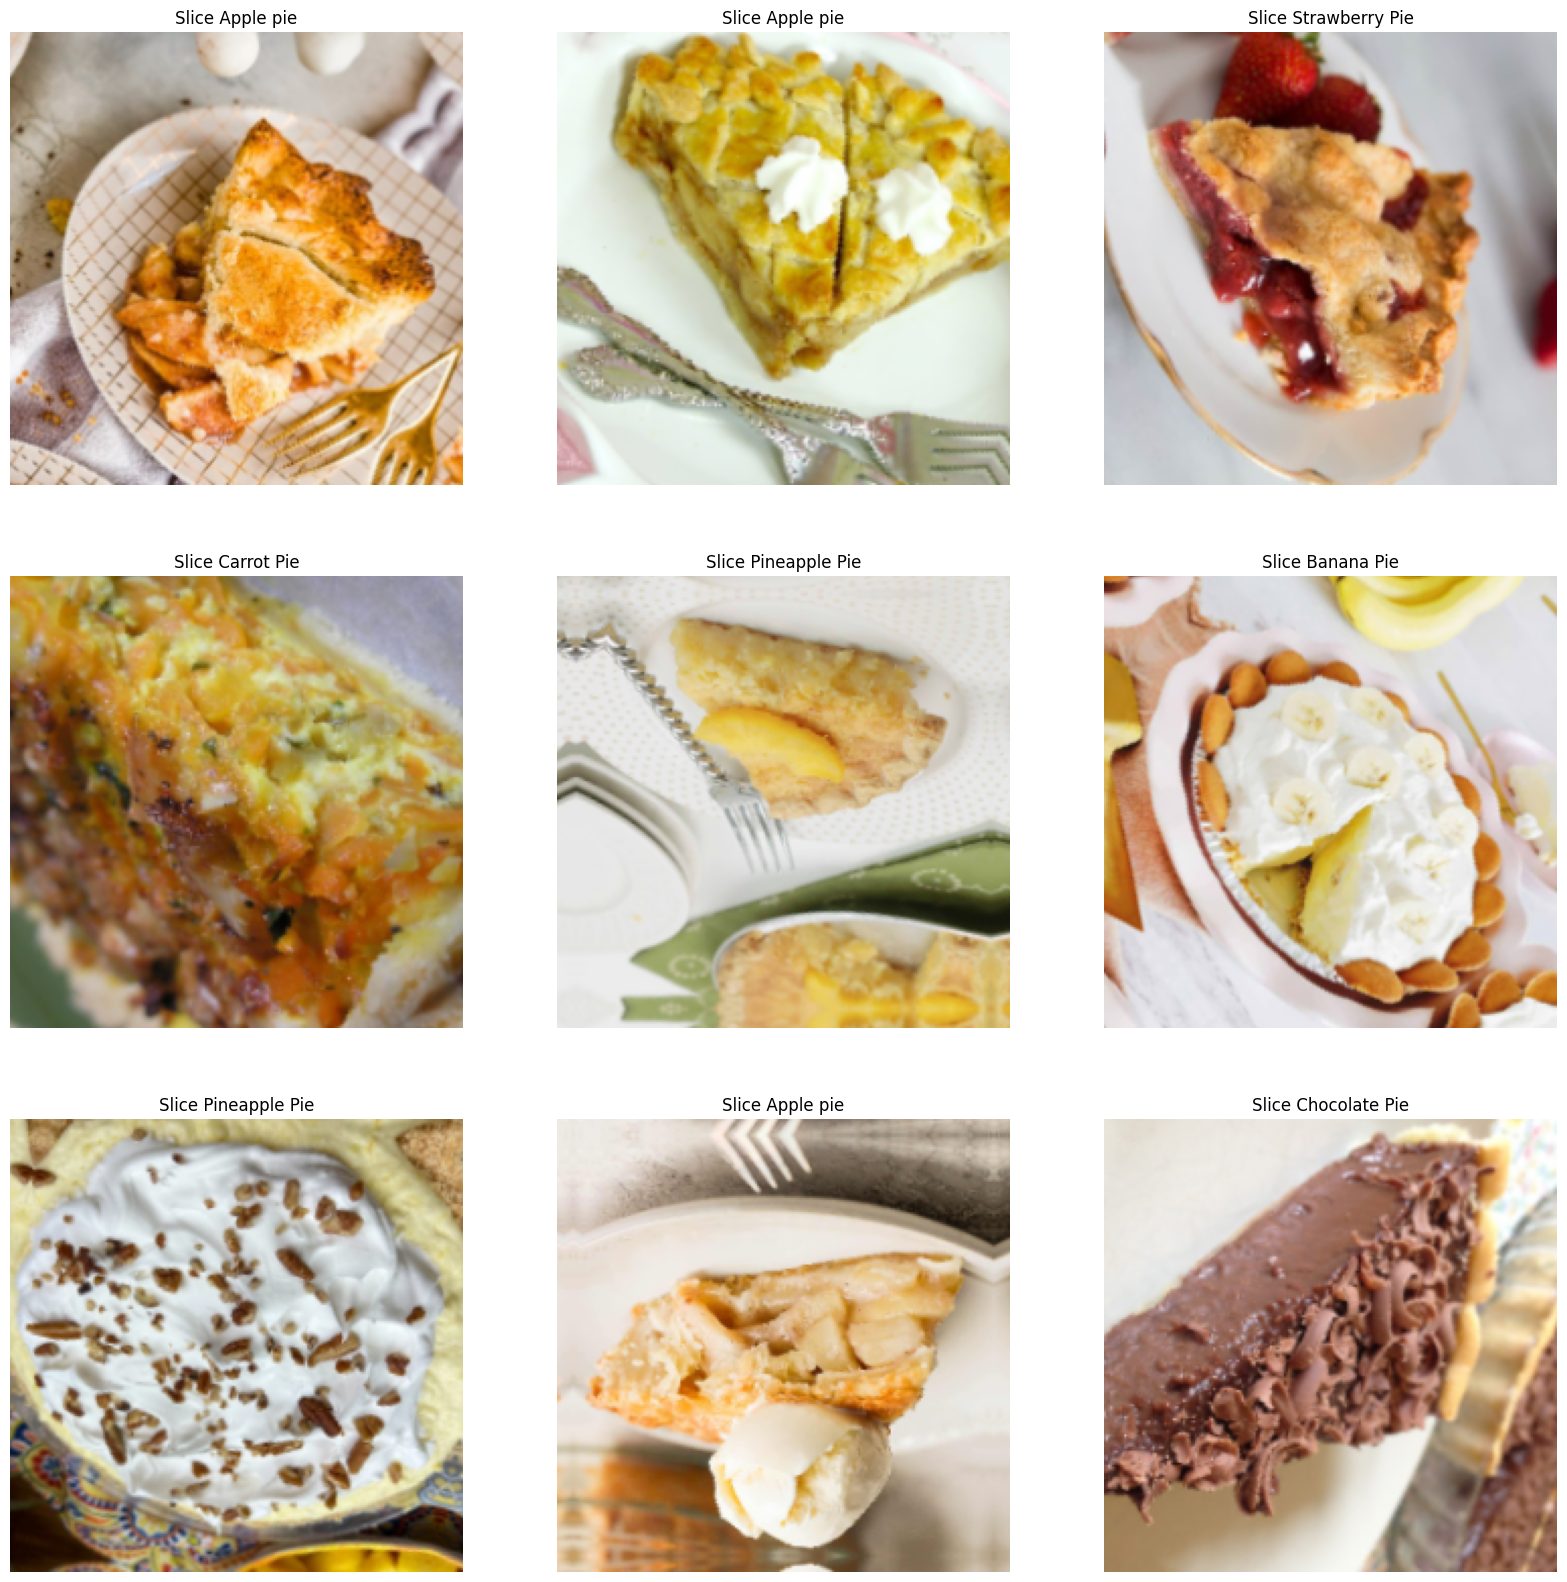

In [10]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image

plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    augment_img = augment_images([open_image(rowdata.path)])[0]
    plt.imshow(augment_img)
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1
    
plt.show()

    

## Define model

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(), 
        # TODO: ...
        Dense(2048, activation='relu'),
        Dropout(0.5),   
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(LABEL_NAMES), activation='softmax')
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers
    for layer in base_model.layers:
        layer.trainable = False
    
    
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [12]:
get_model().summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']       

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [ ]:
from pandas.core.interchange import dataframe
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = train_df.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 25

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    try:

        train_images = augment_images(open_images(total_train_paths[train_index]))
        train_labels = total_train_labels[train_index]

        val_images = open_images(total_train_paths[val_index])
        val_labels = total_train_labels[val_index]
    finally:
        print("dommage")

    model = get_model() # We reinitialize the model

    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

# Results

**TODO**: plot the results from your crossvalidation

In [ ]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)

    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


In [ ]:

import matplotlib.pyplot as plt



fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

In [ ]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

In [ ]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

In [ ]:
import sklearn.metrics as me
QUERIES = ["Slice Apple pie",
                     "Slice Strawberry Pie",
                     "Slice Apricots Pie",
                     "Slice Pumpkin Pie",
                     "Slice Pineapple Pie",
                     "Slice Cherry Pie",
                     "Slice Carrot Pie",
                     "Slice Banana Pie",
                     "Slice Chocolate Pie"
                     ]
test_images = open_images(test_paths)

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(QUERIES)))

In [ ]:


confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=QUERIES,
)

confusion_matrix_display.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# F1 score
f1_score = me.f1_score(test_labels, pred, average='macro')
print(f"F1 score: {f1_score}")


### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

In [ ]:
import matplotlib.pyplot as plt

# Get the predictions for the test set
preds = model.predict(test_images)

# Convert predictions from probabilities to class labels
pred_labels = np.argmax(preds, axis=1)

# Find the indices of the misclassified images
misclassified_indices = np.where(pred_labels != test_labels)[0]

# Select the first few misclassified images
misclassified_images = test_images[misclassified_indices[:5]]
misclassified_labels = pred_labels[misclassified_indices[:5]]
true_labels = test_labels[misclassified_indices[:5]]

# Plot the misclassified images along with their predicted and actual labels
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, (img, pred_label, true_label) in enumerate(zip(misclassified_images, misclassified_labels, true_labels)):
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {LABEL_NAMES[pred_label]},\nActual: {LABEL_NAMES[true_label]}")
    axes[i].axis('off')
plt.show()

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 5

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")


        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

In [ ]:
# Identify misclassified images
misclassified_df = pd.DataFrame(columns=train_df.columns.tolist() + ['predicted_label'])

for _, rowdata in train_df.iterrows():
    img = open_image(rowdata.path)
    pred = model(np.expand_dims(img, axis=0))
    predicted_label = LABEL_NAMES[np.argmax(pred)]

    if predicted_label != rowdata['label']:
        misclassified_df = misclassified_df.add(pd.Series(rowdata.tolist() + [predicted_label], index=misclassified_df.columns))

# Plot misclassified images with GradCAM++
fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

i = 0
for _, rowdata in misclassified_df[misclassified_df['predicted_label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
    img = open_image(rowdata.path)
    pred = model(np.expand_dims(img, axis=0))

    # Generate cam with GradCAM++
    score = CategoricalScore(np.argmax(pred))
    cam = gradcam(score, img)
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    axs[i, label_idx].imshow(img, vmin=0, vmax=1)
    axs[i, label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    axs[i, label_idx].axis("off")

    i += 1

plt.tight_layout()
plt.show()

**TODO**: try to determine what caused the misclassifcations and what you can do about it

In [ ]:
import tensorflow as tf
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils
# install tflite-support 2.10.0
# Task Library expects label files that are in the same format as the one below.
QUERIES = ["Slice Apple pie",
                     "Slice Strawberry Pie",
                     "Slice Apricots Pie",
                     "Slice Pumpkin Pie",
                     "Slice Pineapple Pie",
                     "Slice Cherry Pie",
                     "Slice Carrot Pie",
                     "Slice Banana Pie",
                     "Slice Chocolate Pie"
                     ]

LABEL_FILE = "labels.txt"
SAVE_TO_PATH = "MyModel.tflite"

# Create the labels file
with open(LABEL_FILE, 'w') as label_file:
    for label in QUERIES: # /!\ class_names variable must contains the names of the labels you have.
        label_file.write("{}\n".format(label))

tflite_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()

# Save the model.
with open(SAVE_TO_PATH, 'wb') as f:
    f.write(tflite_model)

ImageClassifierWriter = image_classifier.MetadataWriter

# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
INPUT_NORM_MEAN = 127.5
INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(SAVE_TO_PATH),
    [INPUT_NORM_MEAN],
    [INPUT_NORM_STD],
    [LABEL_FILE]
)

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), SAVE_TO_PATH)